# COVID-19 Data Analysis + World Happiness Correlation
This notebook walks through loading, cleaning, analyzing, visualizing, and merging a COVID-19 dataset with the World Happiness dataset to explore potential relationships between pandemic impact and happiness indicators.

**Contents**
1. Load data
2. Inspect schema
3. Clean & standardize
4. Engineer COVID aggregates
5. Prepare happiness indicators
6. Merge & correlations
7. Visualizations
8. Key insights


## 1. Imports & Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


## 2. Load Data

In [6]:
covid_df = pd.read_csv('covid19_Confirmed_dataset.csv')
happy_df = pd.read_csv('worldwide_happiness_report.csv')
covid_df.head(), happy_df.head()

(  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
 0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
 1            NaN        Albania  41.1533  20.1683        0        0        0   
 2            NaN        Algeria  28.0339   1.6596        0        0        0   
 3            NaN        Andorra  42.5063   1.5218        0        0        0   
 4            NaN         Angola -11.2027  17.8739        0        0        0   
 
    1/25/20  1/26/20  1/27/20  ...  4/21/20  4/22/20  4/23/20  4/24/20  \
 0        0        0        0  ...     1092     1176     1279     1351   
 1        0        0        0  ...      609      634      663      678   
 2        0        0        0  ...     2811     2910     3007     3127   
 3        0        0        0  ...      717      723      723      731   
 4        0        0        0  ...       24       25       25       25   
 
    4/25/20  4/26/20  4/27/20  4/28/20  4/29/20  4/30/20  
 0     

## 3. Inspect Schema

In [8]:
covid_df.info()
print('\n')
happy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Columns: 104 entries, Province/State to 4/30/20
dtypes: float64(2), int64(100), object(2)
memory usage: 216.3+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Overall rank                  156 non-null    int64  
 1   Country or region             156 non-null    object 
 2   Score                         156 non-null    float64
 3   GDP per capita                156 non-null    float64
 4   Social support                156 non-null    float64
 5   Healthy life expectancy       156 non-null    float64
 6   Freedom to make life choices  156 non-null    float64
 7   Generosity                    156 non-null    float64
 8   Perceptions of corruption     156 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 11.1+

## 4. Helpers for flexible column detection & cleaning

In [10]:
def guess_col(df, candidates):
    cols_lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand.lower() in cols_lower:
            return cols_lower[cand.lower()]
    for cand in candidates:
        for col in df.columns:
            if cand.lower() in col.lower():
                return col
    return None

def std_country(s):
    if pd.isna(s):
        return s
    s = str(s).strip()
    replacements = {
        "United States of America": "United States",
        "USA": "United States",
        "US": "United States",
        "U.S.": "United States",
        "UK": "United Kingdom",
        "U.K.": "United Kingdom",
        "Russian Federation": "Russia",
        "Viet Nam": "Vietnam",
        "Czechia": "Czech Republic",
        "Congo (Kinshasa)": "Democratic Republic of the Congo",
        "Congo, Dem. Rep.": "Democratic Republic of the Congo",
        "Congo (Brazzaville)": "Republic of the Congo",
        "Korea, South": "South Korea",
        "Korea, Republic of": "South Korea",
        "Korea, North": "North Korea",
        "Taiwan*": "Taiwan",
        "Hong Kong S.A.R. of China": "Hong Kong",
        "Mainland China": "China",
    }
    return replacements.get(s, s)

## 5. Detect key columns dynamically (works across variants of these datasets)

In [12]:
cov_country_col = guess_col(covid_df, ["location", "country", "country/region", "country or region", "entity", "region", "Area"])
cov_date_col    = guess_col(covid_df, ["date", "observationdate", "day"])
cov_cases_col   = guess_col(covid_df, ["total_cases", "confirmed", "cases", "cumulative cases", "cumulative_confirmed"])
cov_deaths_col  = guess_col(covid_df, ["total_deaths", "deaths", "cumulative deaths"])
cov_new_cases_col = guess_col(covid_df, ["new_cases", "daily new cases", "new confirmed"])
cov_new_deaths_col = guess_col(covid_df, ["new_deaths", "daily new deaths"])

hap_country_col = guess_col(happy_df, ["country", "country name", "country or region", "nation"])
hap_score_col   = guess_col(happy_df, ["score", "happiness score", "life ladder"])
hap_gdp_col     = guess_col(happy_df, ["gdp per capita", "economy (gdp per capita)", "logged gdp per capita", "gdp"])
hap_social_col  = guess_col(happy_df, ["social support", "social_support"])
hap_health_col  = guess_col(happy_df, ["healthy life expectancy", "health (life expectancy)", "life expectancy"])
hap_freedom_col = guess_col(happy_df, ["freedom", "freedom to make life choices"])

print(cov_country_col, cov_date_col, cov_cases_col, cov_deaths_col, cov_new_cases_col, cov_new_deaths_col)
print(hap_country_col, hap_score_col, hap_gdp_col, hap_social_col, hap_health_col, hap_freedom_col)

Country/Region None None None None None
Country or region Score GDP per capita Social support Healthy life expectancy Freedom to make life choices


## 6. Clean + Standardize

In [14]:
covid_work = covid_df.copy()
happy_work = happy_df.copy()

covid_work[cov_country_col] = covid_work[cov_country_col].apply(std_country)
happy_work[hap_country_col] = happy_work[hap_country_col].apply(std_country)

if cov_date_col is not None:
    covid_work[cov_date_col] = pd.to_datetime(covid_work[cov_date_col], errors="coerce")

covid_std = covid_work.rename(columns={cov_country_col: "Country"})
happy_std = happy_work.rename(columns={hap_country_col: "Country"})

## 7. Build/Align COVID metrics (cumulative & daily)

In [16]:
cov_new_cases_col = cov_new_cases_col
cov_new_deaths_col = cov_new_deaths_col
cov_cases_col = cov_cases_col
cov_deaths_col = cov_deaths_col

# Build cumulative if only daily exists
if cov_cases_col is None and cov_new_cases_col is not None:
    covid_std = covid_std.sort_values(["Country", cov_date_col])
    covid_std["__total_cases_built__"] = covid_std.groupby("Country")[cov_new_cases_col].cumsum()
    cov_cases_col = "__total_cases_built__"

if cov_deaths_col is None and cov_new_deaths_col is not None:
    covid_std = covid_std.sort_values(["Country", cov_date_col])
    covid_std["__total_deaths_built__"] = covid_std.groupby("Country")[cov_new_deaths_col].cumsum()
    cov_deaths_col = "__total_deaths_built__"

# Build daily if only cumulative exists
if cov_new_cases_col is None and cov_cases_col is not None and cov_date_col is not None:
    covid_std = covid_std.sort_values(["Country", cov_date_col])
    covid_std["__new_cases_built__"] = covid_std.groupby("Country")[cov_cases_col].diff().fillna(0)
    cov_new_cases_col = "__new_cases_built__"

if cov_new_deaths_col is None and cov_deaths_col is not None and cov_date_col is not None:
    covid_std = covid_std.sort_values(["Country", cov_date_col])
    covid_std["__new_deaths_built__"] = covid_std.groupby("Country")[cov_deaths_col].diff().fillna(0)
    cov_new_deaths_col = "__new_deaths_built__"

## 8. Aggregate to latest snapshot + peaks

In [18]:
keep_cols = ["Country"]
if cov_date_col is not None:
    keep_cols.append(cov_date_col)
for col in [cov_cases_col, cov_deaths_col, cov_new_cases_col, cov_new_deaths_col]:
    if col is not None:
        keep_cols.append(col)

cov_keep = covid_std[keep_cols].copy()
if cov_date_col is not None:
    cov_keep = cov_keep.sort_values(["Country", cov_date_col])

if cov_new_cases_col is not None and cov_date_col is not None:
    cov_keep["new_cases_7d"] = cov_keep.groupby("Country")[cov_new_cases_col].transform(lambda s: s.rolling(7, min_periods=1).mean())
if cov_new_deaths_col is not None and cov_date_col is not None:
    cov_keep["new_deaths_7d"] = cov_keep.groupby("Country")[cov_new_deaths_col].transform(lambda s: s.rolling(7, min_periods=1).mean())

if cov_date_col is not None:
    idx = cov_keep.groupby("Country")[cov_date_col].idxmax()
    covid_latest = cov_keep.loc[idx].copy()
else:
    covid_latest = cov_keep.groupby("Country").tail(1).copy()

if cov_cases_col and cov_cases_col in covid_latest.columns and cov_cases_col != "total_cases":
    covid_latest = covid_latest.rename(columns={cov_cases_col: "total_cases"})
if cov_deaths_col and cov_deaths_col in covid_latest.columns and cov_deaths_col != "total_deaths":
    covid_latest = covid_latest.rename(columns={cov_deaths_col: "total_deaths"})

if "total_deaths" in covid_latest.columns and "total_cases" in covid_latest.columns:
    covid_latest["CFR"] = np.where(covid_latest["total_cases"] > 0, covid_latest["total_deaths"] / covid_latest["total_cases"], np.nan)

for col in ["new_cases_7d", "new_deaths_7d"]:
    if col in cov_keep.columns:
        peak = cov_keep.groupby("Country")[col].max().rename(f"peak_{col}")
        covid_latest = covid_latest.merge(peak, on="Country", how="left")

covid_latest.head()

,Country
0,Afghanistan
1,Albania
2,Algeria
3,Andorra
4,Angola


## 9. Prepare Happiness indicators

In [20]:
rename_map = {}
if hap_score_col: rename_map[hap_score_col] = "HappinessScore"
if hap_gdp_col: rename_map[hap_gdp_col] = "GDP_per_capita"
if hap_social_col: rename_map[hap_social_col] = "Social_support"
if hap_health_col: rename_map[hap_health_col] = "Healthy_life_expectancy"
if hap_freedom_col: rename_map[hap_freedom_col] = "Freedom"

happy_features = happy_std[["Country"] + [c for c in [hap_score_col, hap_gdp_col, hap_social_col, hap_health_col, hap_freedom_col] if c is not None]].rename(columns=rename_map)

hap_year_col = guess_col(happy_std, ["year"])
if hap_year_col and hap_year_col in happy_std.columns:
    happy_features = happy_std.sort_values(["Country", hap_year_col]).groupby("Country").tail(1)[["Country"] + list(rename_map.keys())].rename(columns=rename_map)

happy_features.head()

,Country,HappinessScore,GDP_per_capita,Social_support,Healthy_life_expectancy,Freedom
0,Finland,7.769,1.340,1.587,0.986,0.596
1,Denmark,7.600,1.383,1.573,0.996,0.592
2,Norway,7.554,1.488,1.582,1.028,0.603
3,Iceland,7.494,1.380,1.624,1.026,0.591
4,Netherlands,7.488,1.396,1.522,0.999,0.557


## 10. Merge & correlate

In [22]:
merged = covid_latest.merge(happy_features, on="Country", how="inner")
if "total_cases" in merged.columns:
    merged["log_total_cases"] = merged["total_cases"].apply(lambda x: np.log10(x) if pd.notna(x) and x > 0 else np.nan)
if "total_deaths" in merged.columns:
    merged["log_total_deaths"] = merged["total_deaths"].apply(lambda x: np.log10(x) if pd.notna(x) and x > 0 else np.nan)

num_cols = [c for c in ["CFR", "total_cases", "total_deaths", "log_total_cases", "log_total_deaths",
                        "HappinessScore", "GDP_per_capita", "Social_support", "Healthy_life_expectancy", "Freedom"]
            if c in merged.columns]
corr = merged[num_cols].corr(method="pearson")
corr.round(3)

,HappinessScore,GDP_per_capita,Social_support,Healthy_life_expectancy,Freedom
HappinessScore,1.000,0.799,0.791,0.800,0.573
GDP_per_capita,0.799,1.000,0.761,0.864,0.377
Social_support,0.791,0.761,1.000,0.764,0.451
Healthy_life_expectancy,0.800,0.864,0.764,1.000,0.407
Freedom,0.573,0.377,0.451,0.407,1.000


## 11. Visualizations (matplotlib, one-per-figure, no custom colors)

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

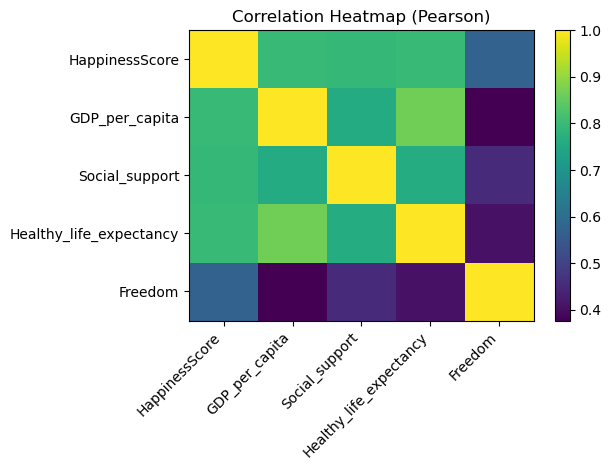

In [24]:
import matplotlib.pyplot as plt
from pathlib import Path
fig_dir = Path("./figures")
fig_dir.mkdir(exist_ok=True)

plt.figure()
if "total_cases" in covid_latest.columns:
    top_cases = covid_latest.sort_values("total_cases", ascending=False).head(10)
    plt.bar(top_cases["Country"], top_cases["total_cases"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top 10 Countries by Total COVID Cases (Latest Snapshot)")
    plt.xlabel("Country")
    plt.ylabel("Total Cases")
    plt.tight_layout()
    plt.savefig(fig_dir / "top10_total_cases.png", dpi=200)
    plt.show()

plt.figure()
if "total_deaths" in covid_latest.columns:
    top_deaths = covid_latest.sort_values("total_deaths", ascending=False).head(10)
    plt.bar(top_deaths["Country"], top_deaths["total_deaths"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Top 10 Countries by Total COVID Deaths (Latest Snapshot)")
    plt.xlabel("Country")
    plt.ylabel("Total Deaths")
    plt.tight_layout()
    plt.savefig(fig_dir / "top10_total_deaths.png", dpi=200)
    plt.show()

plt.figure()
if "HappinessScore" in merged.columns and "CFR" in merged.columns:
    plt.scatter(merged["HappinessScore"], merged["CFR"])
    plt.title("Happiness Score vs COVID Case Fatality Rate (CFR)")
    plt.xlabel("Happiness Score")
    plt.ylabel("CFR (Deaths / Cases)")
    plt.tight_layout()
    plt.savefig(fig_dir / "scatter_happiness_vs_cfr.png", dpi=200)
    plt.show()

plt.figure()
if "GDP_per_capita" in merged.columns and "log_total_deaths" in merged.columns:
    plt.scatter(merged["GDP_per_capita"], merged["log_total_deaths"])
    plt.title("GDP per Capita vs Log10(Total COVID Deaths)")
    plt.xlabel("GDP per Capita (Happiness dataset scale)")
    plt.ylabel("log10(Total COVID Deaths)")
    plt.tight_layout()
    plt.savefig(fig_dir / "scatter_gdp_vs_logdeaths.png", dpi=200)
    plt.show()

plt.figure()
im = plt.imshow(corr.values, aspect="auto")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=45, ha="right")
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Heatmap (Pearson)")
plt.colorbar(im)
plt.tight_layout()
plt.savefig(fig_dir / "correlation_heatmap.png", dpi=200)
plt.show()

## 12. Quick, human-readable insights
- **CFR** gives the share of confirmed cases resulting in death. Compare it across countries but beware of testing differences.
- Check the scatter plots to see patterns (e.g., higher happiness vs lower CFR). Correlations quantify direction/strength but do not imply causality.
- The GDP per capita vs log deaths chart uses a log transform so countries with extremely high totals do not dominate the scale.